In [13]:
#!pip install chatarena[all]
#!pip install openai==0.27.2
#!pip install networkx
#!pip install matplotlib
#!pip install pillow

#!pip install -q -U google-generativeai

In [14]:
#!pip install accelerate>=0.26.0

In [15]:
#!huggingface-cli login

In [16]:
from chatarena.environments.base import TimeStep, Environment
from chatarena.message import Message, MessagePool
from chatarena.utils import extract_jsons
import networkx as nx
import random
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import google.generativeai as genai
import os
import time
import csv
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import pipeline
import transformers
import torch
from accelerate import disk_offload
import numpy as np

import os






In [17]:
import logging

logging.basicConfig(level = logging.INFO)

logger = logging.getLogger(__name__)


In [18]:

torch.cuda.empty_cache()


In [19]:
model = "meta-llama/Llama-3.1-8B-Instruct"
# utilize Llama Model
class LlamaModel():
    def __init__(self):
        self.model_name = model
        self.tokenizer = None
        self.pipeline = None
        self.__load_model__()
        
        
    def __load_model__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_auth_token = True)
        
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_name,
            torch_dtype=torch.float16,
            tokenizer = self.tokenizer,
            device_map="auto",
            #load_in_8bit = True
            )
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
    
    def generate_response(self, query):

        try:
            query = "[INST]" + query + "[/INST]"
            #print(query)

            sequences = self.pipeline(
                query,
                do_sample=True,
                top_k=10,
                num_return_sequences=1,
                max_length=1024,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
                truncation = True
                )
            #print(sequences)

            generated_text = sequences[0]['generated_text']
            #print(f"generated_text: {generated_text}")
            sequence_return = generated_text[len(query):].strip()
            sequence_return = sequence_return.replace("[INST]", "").replace("[/INST]", "").strip()
            #print(f"Return: {sequence_return}")
            return sequence_return

        except Exception as e:
            return "Error"
        


In [20]:
def generate_network(num_nodes = 8, network = "spatial", edge_prob=0.3):
    """
    Generate a random network with a specified number of nodes.

    Parameters:
    num_nodes (int): The number of nodes in the graph.
    network (str): Type of network: we have 'spatial' for spatially-embeddded or 'homogeneous' for fully-connected in this case
    edge_prob (float): The probability of creating an edge between any two nodes.

    Returns:
    G (networkx.Graph): A randomly generated graph.
    """
    # Generate an empty graph
    G = nx.Graph()
    
    # Add nodes to the graph
    labels = {i: f"player #{i+1}" for i in range(num_nodes)}
    G.add_nodes_from(labels.keys())
    nx.set_node_attributes(G, labels, 'name')
    
    # for spatial network
    if network == "spatial": 
        # Add edges between nodes with a probability of edge_prob
        for i in range(num_nodes):
            G.add_edge(i, (i+1) % num_nodes)
            if num_nodes > 2:
                G.add_edge(i, (i+2) % num_nodes)
    
    # for homogeneous network where everything is connected
    elif network == "homogeneous":
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if random.random() < edge_prob:
                    G.add_edge(i, j)
    
    return G




In [21]:
# sample event 
def hashtag_event():
    event = '''The Fukushima Nuclear Disaster was a 2011 nuclear accident at the Daiichi Nuclear Power Plant in Fukushima, Japan. The cause of the nuclear disaster was the Tōhoku earthquake on March 11, 2011, the most powerful earthquake ever recorded in Japan. The earthquake triggered a tsunami with waves up to 130 feet tall, with 45 foot tall waves causing direct damage to the nuclear power plant. The damage inflicted dramatic harm both locally and globally. 
The damage caused radioactive isotopes in reactor coolant to discharge into the sea, therefore Japanese authorities quickly implemented a 100-foot exclusion zone around the power plant. Large quantities of radioactive particles were found shortly after throughout the Pacific Ocean and reached the California coast.

The exclusion zone resulted in the  displacement of approximately 156,000 people in years to follow. Independent commissions continue to recognize that affected residents are still struggling and facing grave concerns. Indeed, a WHO report predicts that infant girls exposed to the radiation are 70% more likely to develop thyroid cancer.  
The resulting energy shortage inspired media campaigns to encourage Japanese households and businesses to cut back on electrical usage, which led to the national movement Setsuden ("saving electricity"). The movement caused a dramatic decrease in the country's energy consumption during the crisis and later inspired the Japanese government to pass a battery of policies focused on reducing the energy consumption of large companies and households.'''
    


    return event

In [22]:
def generate_hashtags_llama(player_name, event, llama, previous_guesses = None, current_round = 1):
    """
    Generate a hashtags for each player associated with the event

    Parameters:
    player_name (str): The player/agents in the game
    llama: the Llama model used
    event (str): The event that is being described 
    previous_guesses (list): list containin the round number, player previous hashtags and its previous neighbors' hashtags
    current_round (int): current round
    
    Returns:
    hashtag generated for each player
    """
    

    #previous_guesses = previous_guesses or []
    # table containing each player, their previous hashtag, and their neighbor's previous guesses
    previous_table = "Round, Your Guess, Neighbor's Guess\n"
    
    # add the round number, player previous hashtags, and player's neighbors' previous hashtags to the table
    if previous_guesses and current_round > 1:
        previous_rows = [f"{round_num}, {player_hashtag}, {neighbor_hashtag}" 
                        for round_num, player_hashtag, neighbor_hashtag in previous_guesses]
                       
        previous_table += "\n".join(previous_rows)
        print(f"{previous_table} \n")
    
        
    # for rounds after round 1, Llama is asked to generate hashtags relevent to the event based on previous neighboring hashtags
    if current_round > 1:
        
        prompt = (f"In the experiment you are awarded with 1 point if you guess the same hashtag as your randomly-assigned neighbor, and 0 points if you don't guess the same hashtag. Your goal is to earn as many points as possible."
                  f"You are in round {current_round} of the experiment. Your guesses, and your neighbors guesses have been as follows, as represented in the CSV below.\n"
                  f"\n"
                  f"{previous_table}\n"
                  f"\n"
                  f"Based on this information, and the scenario provided to you, please guess a hashtag for this scenario with the goal of matching your randomly-assigned neighbor in this round."
                 f"You can use your hashtag from last round but don't always use it especially if you do not believe your next neighbor will have that hashtag.")
        #print(prompt)
    # otherwise for just round 1, Llama generates hashtags relevant to the event without influence from neighbors
    else: 
        prompt = f"\n\nGenerate a single hashtag relevant to the event:\n\n{event}. Only generate a hashtag that you believe is meaningful to the event. Be sure to incldue # in front of the word."
        

    # retries in case initial generation does not work
    max_retries = 1
    retries = 0

    while retries < max_retries:
        try:
    
            response = llama.generate_response(prompt)
            #print(response)
        
            # extract the hashtags
            hashtags = [word.strip(",.:*)([]") for word in response.split() if word.startswith("#") and len(word) > 1 and word != '##']
            if hashtags:
                return hashtags[0]
                
        # in case of error, try to generate hashtag again as long as it is within the maximum number of retries
        except Exception as e:
            print(f"Llama unable to generate hashtags, error: {e}.")

        retries += 0

    return "#backup"

    # if retries exceeded and still no hashtag generated, just return backupHashtag
    #return previous_guesses[-1][1] if previous_guesses[-1][1] else "#BackupHashtag"

In [23]:
class HashtagMessagePassing(Environment):
    type_name = "hashtag_message_passing"

    def __init__(self, network_graph, total_rounds = 30):
        
        """
        Initialize the game environment for hashtag message passing.
        """
          
        self.network_graph = network_graph
        self.node_to_player = {}
        self.player_to_node = {}
       
        # for mapping each player name to corresponding node number in graph
        for node in self.network_graph.nodes:
            player_name = self.network_graph.nodes[node]['name']
            self.node_to_player[node] = player_name
            self.player_to_node[player_name] = node
            
        self.previous_hashtags = []
        self.previous_neighbors = []
        self.player_names = list(self.player_to_node.keys())
        self.total_rounds = total_rounds
        self.cur_round = 1
        super().__init__(player_names=self.player_names)
        self.turn = 0
        self.message_pool = MessagePool()
        self.selected_hashtags = {}
        self.selected_hashtag_history = []
        self.scores = {player: 0 for player in self.player_names}
        self.round_scores = {}
        self.neighbor_previous_hashtag = {player: {} for player in self.player_names}
        self.cur_neighbor = {}
        self._terminal = False
        self.event = hashtag_event()
        self.llama = LlamaModel()
        self.reset()
    

    def _moderator_speak(self, text: str, visible_to: Union[str, List[str]] = "all"):
        """
        moderator say something to players
        """
        message = Message(agent_name="Moderator", content=text, turn=self.turn, visible_to=visible_to)
        self.message_pool.append_message(message)

    def reset(self):
        
        """
        Reset the game for each new round
        """
        
        self.player_names = list(nx.get_node_attributes(self.network_graph, 'name').values())
        # randomize player names for pairing
        random.shuffle(self.player_names)
        self.turn = 0
        self.message_pool.reset()
        self._terminal = False       
        #self.selected_hashtag_history.append(self.selected_hashtags.copy())
        self.round_scores = {player: 0 for player in self.player_names}
        self.scored_pairs = set()
        self.selected_hashtags.clear()
        
        if self.cur_neighbor:
            self.previous_neighbors.append(self.cur_neighbor.copy())
        
        self.cur_neighbor = {}
        available_neighbors = self.player_names[:]
        
        while len(available_neighbors) > 1:
            player = available_neighbors.pop()
            neighbor = available_neighbors.pop()
            
            self.cur_neighbor[player] = neighbor
            self.cur_neighbor[neighbor] = player
        
        
            print(f"{player} is paired with {self.cur_neighbor[player]} \n")
        
        
        # Moderator declares the game has started
        self._moderator_speak(f"Round {self.cur_round}: Please provide a hashtag for the event!")
        
        observation = self.get_observation(self.get_next_player())
        

        return TimeStep(observation=observation, reward=None, terminal=False)
   

    def get_observation(self, player_name=None) -> List[Message]:
        
        """
        Send the messages to players
        """
        
        if player_name is None:
            return self.message_pool.get_all_messages()
        else:
            return self.message_pool.get_visible_messages(player_name, turn=self.turn + 1)

    def get_next_player(self) -> str:
        
        """
        returns name of player in list that is up next, or none if everyone has gone
        """
        return self.player_names[-1] if self.player_names else None
    
    def get_neighbor_hashtags(self, player_name):
        
        """
        get the round number, player's previous hashtags and player's neighbors' previous hashtags
        """
        
        previous_hashtags = []
        
        # get each players' previous hashtags and its previous neighbors' hashtags up to its current round
        for round_num in range(1, self.cur_round):
            
            player_previous_hashtag = self.previous_hashtags[round_num - 1].get(player_name)
                                                                               
            previous_neighbor = self.previous_neighbors[round_num - 1].get(player_name)  
            
            neighbor_previous_hashtag = self.previous_hashtags[round_num - 1].get(previous_neighbor)
            
            previous_hashtags.append((round_num, player_previous_hashtag, neighbor_previous_hashtag))
        
        return previous_hashtags

    # export players as a CSV style list
    def export_csv(self, filename = "30_round_hasthags_graph.csv"):

        write_header = not os.path.exists(filename)
        
        with open(filename, 'a', newline = '') as file:
            writer = csv.writer(file)

            if write_header:
                writer.writerow(["Round", "Player", "Hashtag", "Round Points", "Total Points"])
            if self.selected_hashtags:
                for player, hashtag in self.selected_hashtags.items():
                    writer.writerow([
                        self.cur_round,
                        player,
                        hashtag,
                        self.round_scores.get(player, 0),
                        self.scores.get(player, 0)
                
                    ])
    
    def step(self, player_name: str, action: str) -> TimeStep:
        
        """
        the actions a player does during their turn
        """
        # get neighbor
        neighbor = self.cur_neighbor.get(player_name)
        
        previous_guesses = self.get_neighbor_hashtags(player_name)
    
  
        
        # if it is the first round, generate a hashtag based solely on the event
        # otherwise the hashtag should be influenced by the neighbors' choises
        if self.cur_round == 1:
            chosen_hashtag = generate_hashtags_llama(player_name, self.event, self.llama)
        else:
            chosen_hashtag = generate_hashtags_llama(player_name, self.event, self.llama, previous_guesses, self.cur_round)
         
       
        
        # store player's hashtag
        self.selected_hashtags[player_name] = chosen_hashtag
 
        
        print(f"Player: {player_name}, Hashtag: {chosen_hashtag}\n") 
        
        round_points = 0
        
        # if the neighborss hashtags match, set current round point to 1 and increase each players' total points by 1
        # else keep the current round points at 0 and total points the same 
        if neighbor and self.selected_hashtags.get(neighbor) == chosen_hashtag:
            
            pair = tuple(sorted([player_name, neighbor]))
            if pair not in self.scored_pairs:
                round_points = 1
                self.scores[player_name] += round_points
                self.scores[neighbor] += round_points
                self.round_scores[player_name] = round_points
                self.round_scores[neighbor] = round_points
                
                self.scored_pairs.add(pair)
        else: 
            self.round_scores[player_name] = round_points

            
        total_points = self.scores[player_name]
    
        self._moderator_speak(f"{player_name} points this round: {round_points} \n Total points: {total_points}",
                           visible_to = "all")
        
    
        # increase the turn counter
        self.turn += 1
        
        # remove player from list for this round
        if player_name in self.player_names:
            self.player_names.remove(player_name)

       
        
        # if no players remain in list, end this round, and show the current and total points
        if not self.player_names:
            self.previous_hashtags.append(self.selected_hashtags.copy())
            self.selected_hashtag_history.append(self.selected_hashtags.copy())
            
            self.export_csv()
            
            print(f"End of round {self.cur_round}")
            for player, score in self.scores.items():
                print(f"{player}'s points this round: {self.round_scores[player]} \n Total points: {self.scores[player]}")
                
            self.show_spatial_network()
            if self.cur_round < self.total_rounds:
                self.cur_round += 1
                self.reset()
            # end the game when it reaches the last round
            else:
                self._terminal = True

        observation = self.get_observation(self.get_next_player())
        return TimeStep(observation=observation, reward=None, terminal=self._terminal)

        
    

    def show_spatial_network(self):
        
        """
        show network of nodes of users with common hashtags
        """
        
        # layout of nodes using spring layout algo.
        pos = nx.spring_layout(self.network_graph, seed = 17)
        
        # map players to nodes on graph so they match
        player_to_node = {self.network_graph.nodes[node]['name']: node for node in self.network_graph.nodes}


        
        # highlight matching nodes with a color and other
        matched_edges = []

        colors = {}
        color_index = 0 
        
        color_map = plt.colormaps.get_cmap("hsv")
        
        # find the matching edges and give each pair an unique color
        for player, neighbor in self.cur_neighbor.items():
            if neighbor and self.selected_hashtags.get(player) == self.selected_hashtags.get(neighbor):
                node_player = player_to_node[player]
                node_neighbor = player_to_node[neighbor]
                matched_edges.append((node_player, node_neighbor))
                pair_color = mcolors.to_hex(color_map(color_index / max(1, len(self.cur_neighbor))))
                colors[(node_player, node_neighbor)] = pair_color
                color_index += 1
        
        edge_colors = [colors.get(edge, "gray") for edge in self.network_graph.edges]
        
        node_colors = ["red" for i in self.network_graph.nodes]
        
        
        labels = {node: node + 1 for node in self.network_graph.nodes}
        
        fig, ax = plt.subplots(figsize = (8,8))
        
        # graph the network of nodes
        nx.draw(self.network_graph, pos, labels = labels, node_color = node_colors, node_size = 300, edge_color = edge_colors, width = 2, ax = ax)
        
        plt.title("Hashtag Network")
        
        plt.show()

    def coordination(self):

        # probability of coordination for each trial
        prob = []
        total_neighbor_match = 0
        total_pairs = 0

        # from round 1 to the final round
        for t in range(1, self.cur_round + 1):
            
            #count the number of players whose hashtag match their neighbor's in the current trial
            round_data = self.selected_hashtag_history[t-1]
            neighbor_matches = sum(round_data[player] == round_data[self.cur_neighbor[player]]
                                  for player in self.cur_neighbor
                                  if player in round_data and self.cur_neighbor[player] in round_data)
           
            total_neighbor_match += neighbor_matches
            total_pairs += len(self.cur_neighbor)
            # probability of coordination based on the current trial
            prob.append(total_neighbor_match / total_pairs)

        # plot the behavior
        plt.figure(figsize = (10,6))
        plt.plot(range(1, self.cur_round + 1), prob, label = "Probability of Coordination", linewidth = 2)
        plt.xticks(range(1, self.cur_round + 1))
        plt.xlabel("Trial Number")
        plt.ylabel("P(Coordination)")
        plt.title("Coordinated Behavior")
        plt.legend()
        plt.grid(True)
        plt.show()


    def colormap(self):

        player_ids = range(len(self.player_names))
        num_trials = self.cur_round

        # store hashtags for each player
        hashtag_matrix = np.empty((len(player_ids), num_trials), dtype = object)

        # fill hashtag matrix with the appropriate hashtag according to the player id
        for t, round_data in enumerate(self.selected_hashtag_history[:num_trials]):
            for player, hashtag in round_data.items():
                if player in self.player_to_node:
                    player_id = self.player_to_node[player]
                    if player_id < hashtag_matrix.shape[0] and t < hashtag_matrix.shape[1]:
                        hashtag_matrix[player_id, t] = hashtag

        # get unique hashtags from matrix and map it to a numeric value for visualization using a matrix
        unique_hashtags = list(set(hashtag for row in hashtag_matrix for hashtag in row if hashtag))
        hashtag_to_num = {hashtag: i for i, hashtag in enumerate(unique_hashtags)}
        numeric_matrix = np.vectorize(lambda h: hashtag_to_num.get(h, -1))(hashtag_matrix)


        # plot the matrix using a color map based on the number of unique matrices
        plt.figure(figsize = (10,6))
        plt.imshow(numeric_matrix, aspect = "auto", cmap = "cool", interpolation = "nearest")

        # add the hashtag in each cell of the colormap
        for i in range(hashtag_matrix.shape[0]):
            for j in range(hashtag_matrix.shape[1]):
                hashtag = hashtag_matrix[i, j]
                if hashtag:
                    plt.text(j, i, hashtag, ha = "center", va = "center", fontsize = 8, color = "white")

        plt.xticks(ticks = range(num_trials), labels = range(1, num_trials + 1))
        plt.yticks(ticks = range(len(self.player_names)), labels = range(1, len(self.player_names) + 1))
        plt.xlabel("Trial Number")
        plt.ylabel("Node ID")
        plt.title("Hashtags Responses")
        plt.colorbar(label = "Hashtag Categories")

        plt.show()
                

    def play_game(self):
        
        """
        to run the game 
        """
    
        
        # while there are still rounds remaining and the round is still going on, 
        # get the players' hashtag and continue to the next player
        while self.cur_round <= self.total_rounds and not self._terminal:
            player_name = self.get_next_player()
            if player_name:
                action = "hashtag"
                self.step(player_name, action)
            else:
                if not self.player_names:
                    if self.cur_round < self.total_rounds:
                        self.cur_round += 1
                        self.reset()
                    else:
                        self._terminal = True

                else:
                    break

        self.player_names = list(self.player_to_node.keys())
        #print(self.player_names)
        # show the final network and print final scores
        #print("Done")
        self.show_spatial_network()
        print(f"Scores: {self.scores}")

        self.coordination()
        self.colormap()
    


/nas/home/dcao/miniconda3/envs/llmnetwork/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]


player #3 is paired with player #1 

player #6 is paired with player #9 

player #10 is paired with player #2 

player #8 is paired with player #4 

player #7 is paired with player #5 

Player: player #3, Hashtag: #FukushimaDisasterLegacy

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Player: player #6, Hashtag: #FukushimaNuclearDisaster

Player: player #9, Hashtag: #FukushimaDisaster

Player: player #10, Hashtag: #FukushimaDisasterLegacy

Player: player #2, Hashtag: #FukushimaDisasterLegacy

Player: player #8, Hashtag: #FukushimaDisasterAnniversary

Player: player #4, Hashtag: #FukushimaDisasterLegacy

Player: player #7, Hashtag: #FukushimaDisaster

Player: player #5, Hashtag: #FukushimaDisaster

End of round 1
player #1's points this round: 0 
 Total points: 0
player #2's points this round: 1 
 Total points: 1
player #3's points this round: 0 
 Total points: 0
player #4's points this round: 0 
 Total points: 0
player #5's points this round: 1 
 Total points: 1
player #6's p

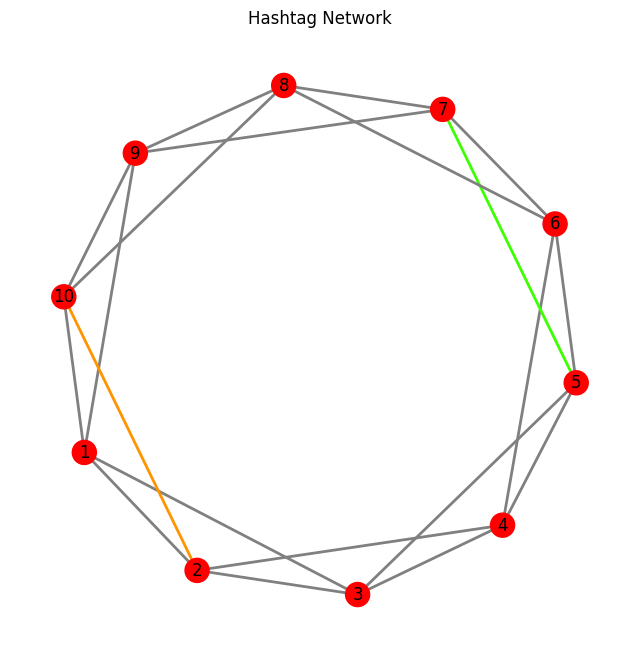

player #9 is paired with player #7 

player #1 is paired with player #10 

player #2 is paired with player #3 

player #4 is paired with player #6 

player #8 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaNuclearDisaster 

Player: player #9, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster 

Player: player #7, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy 

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy 

Player: player #10, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy 

Player: player #2, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery 

Player: player

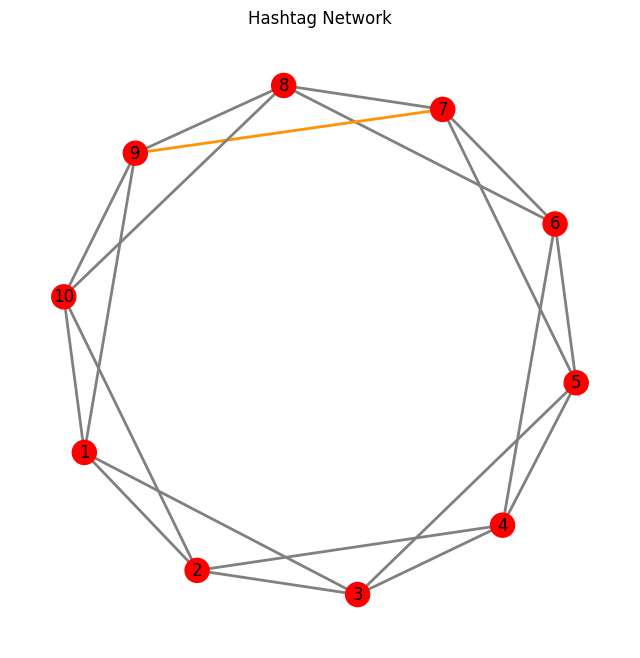

player #8 is paired with player #1 

player #6 is paired with player #7 

player #3 is paired with player #2 

player #5 is paired with player #9 

player #4 is paired with player #10 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster 

Player: player #8, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy 

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy 

Player: player #6, Hashtag: #FukushimaNuclearDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster 

Player: player #7, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1

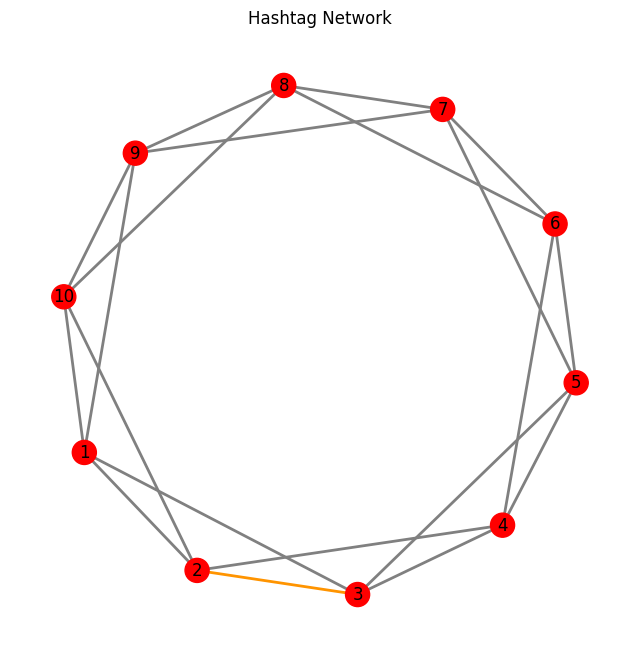

player #8 is paired with player #1 

player #4 is paired with player #3 

player #2 is paired with player #7 

player #10 is paired with player #9 

player #6 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery 

Player: player #8, Hashtag: #FukushimaDisasterAnniversary

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
3, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy 

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterAnniversary
2, #FukushimaDisasterLegacy, #FukushimaNuclearDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy 

Player: player #4, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor

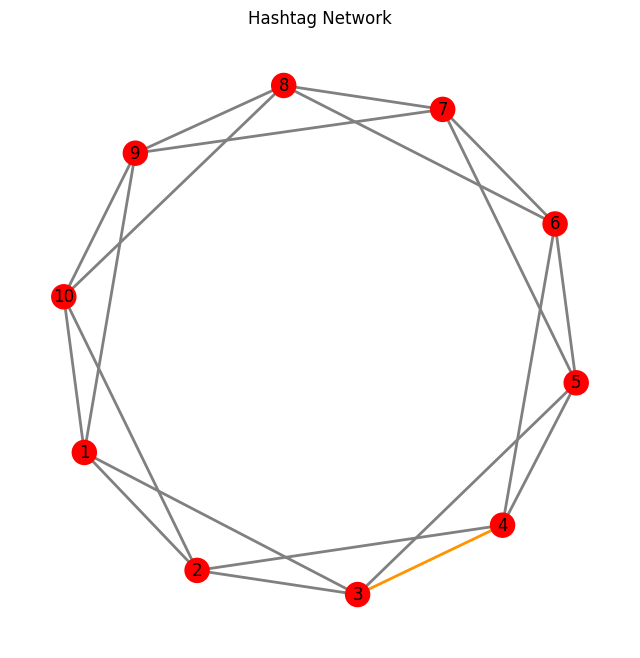

player #1 is paired with player #8 

player #7 is paired with player #6 

player #3 is paired with player #5 

player #2 is paired with player #10 

player #9 is paired with player #4 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
3, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
4, #FukushimaDisasterRecovery, #FukushimaDisasterAnniversary 

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
4, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery 

Player: player #8, Hashtag: #FukushimaDisasterAnniversary

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisas

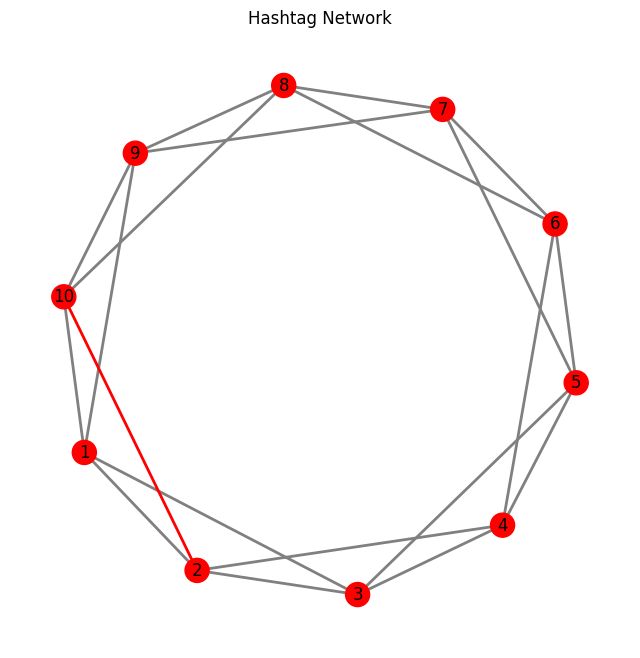

player #1 is paired with player #6 

player #4 is paired with player #3 

player #2 is paired with player #10 

player #5 is paired with player #8 

player #7 is paired with player #9 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
3, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
4, #FukushimaDisasterRecovery, #FukushimaDisasterAnniversary
5, #FukushimaDisasterRecovery, #FukushimaDisasterAnniversary 

Player: player #1, Hashtag: #FukushimaDisasterRecovery

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster 

Player: player #6, Hashtag: #FukushimaNuclearDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterAnn

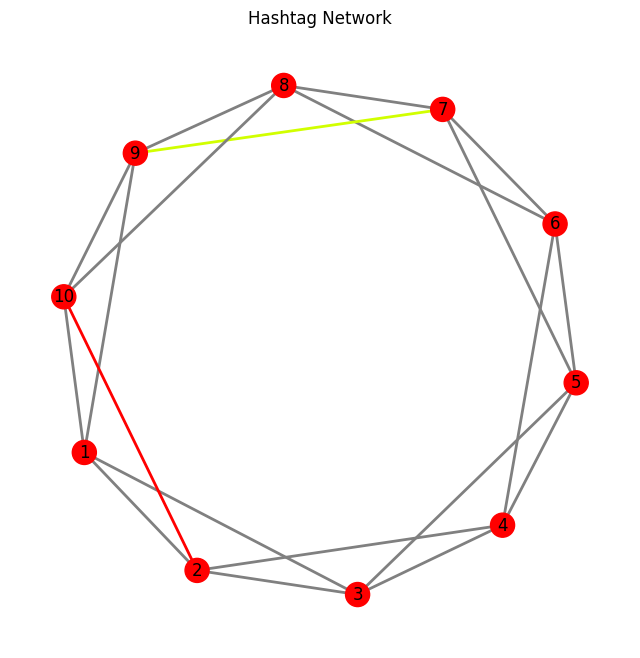

player #9 is paired with player #5 

player #7 is paired with player #4 

player #6 is paired with player #8 

player #10 is paired with player #1 

player #2 is paired with player #3 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaNuclearDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisaster 

Player: player #9, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisasterAnniversary
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaNuclearDisaster
5, #FukushimaDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisasterAnniversary 

Player: player #5, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster

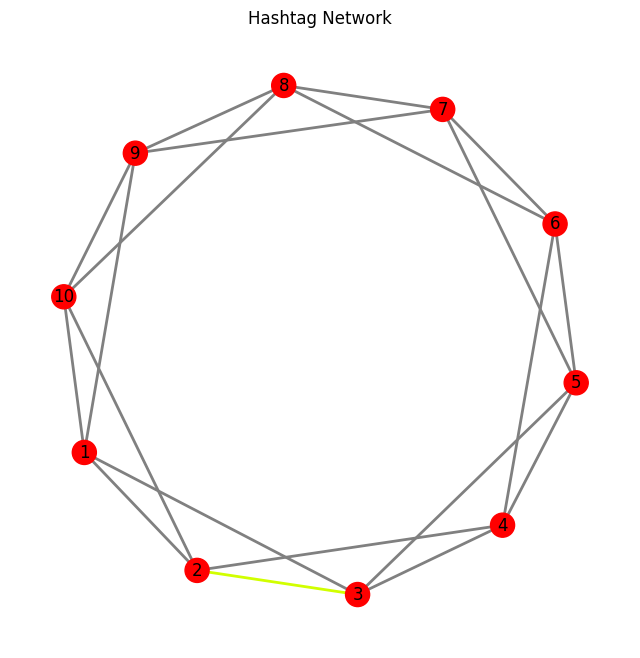

player #1 is paired with player #8 

player #5 is paired with player #2 

player #3 is paired with player #9 

player #4 is paired with player #6 

player #10 is paired with player #7 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
3, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
4, #FukushimaDisasterRecovery, #FukushimaDisasterAnniversary
5, #FukushimaDisasterRecovery, #FukushimaDisasterAnniversary
6, #FukushimaDisasterRecovery, #FukushimaNuclearDisaster
7, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy 

Player: player #1, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
4, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
5, #FukushimaDisasterAnniversary, #FukushimaDisasterRe

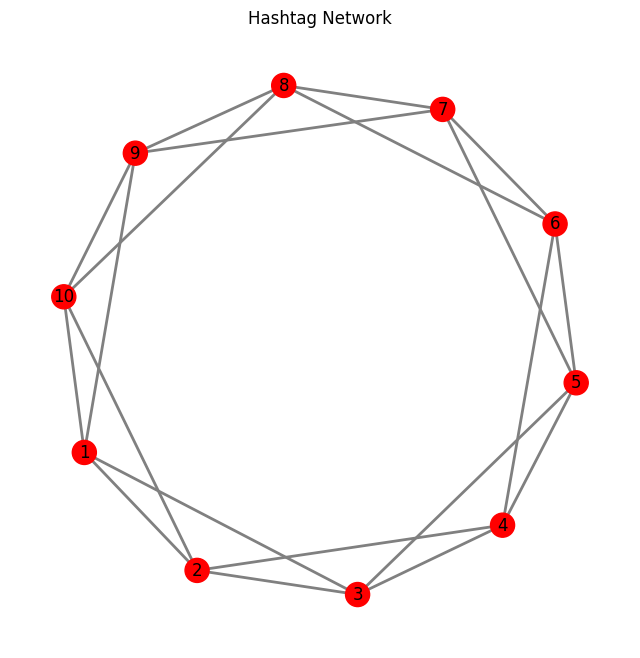

player #9 is paired with player #7 

player #10 is paired with player #1 

player #4 is paired with player #3 

player #2 is paired with player #6 

player #5 is paired with player #8 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaNuclearDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisaster
8, #FukushimaDisaster, #FukushimaDisasterLegacy 

Player: player #9, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaDisaster, #FukushimaNuclearDisaster
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisasterLegacy
8, #

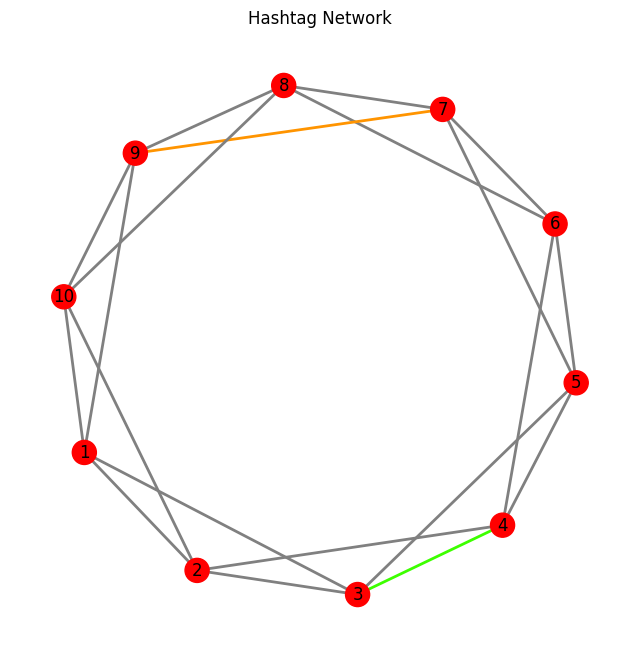

player #5 is paired with player #3 

player #1 is paired with player #4 

player #10 is paired with player #6 

player #2 is paired with player #8 

player #9 is paired with player #7 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisasterAnniversary
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaNuclearDisaster
5, #FukushimaDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisasterAnniversary
7, #FukushimaDisaster, #FukushimaDisaster
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterAnniversary 

Player: player #5, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
2, #ClimateChange, #FukushimaDisasterLegacy
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
5, #FukushimaDisasterLegacy, #FukushimaDisaster
6, #Fu

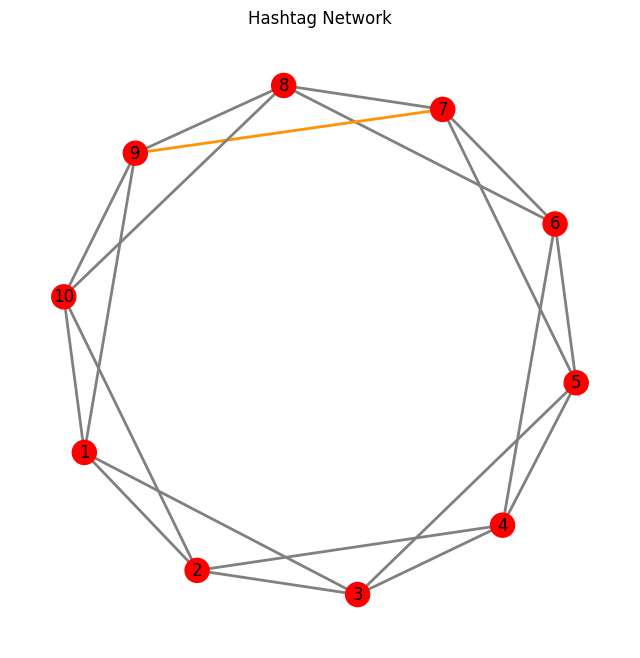

player #5 is paired with player #10 

player #7 is paired with player #9 

player #6 is paired with player #8 

player #1 is paired with player #2 

player #4 is paired with player #3 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisasterAnniversary
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaNuclearDisaster
5, #FukushimaDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisasterAnniversary
7, #FukushimaDisaster, #FukushimaDisaster
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterAnniversary
10, #FukushimaDisaster, #FukushimaDisasterLegacy 

Player: player #5, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
2, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisaster
5

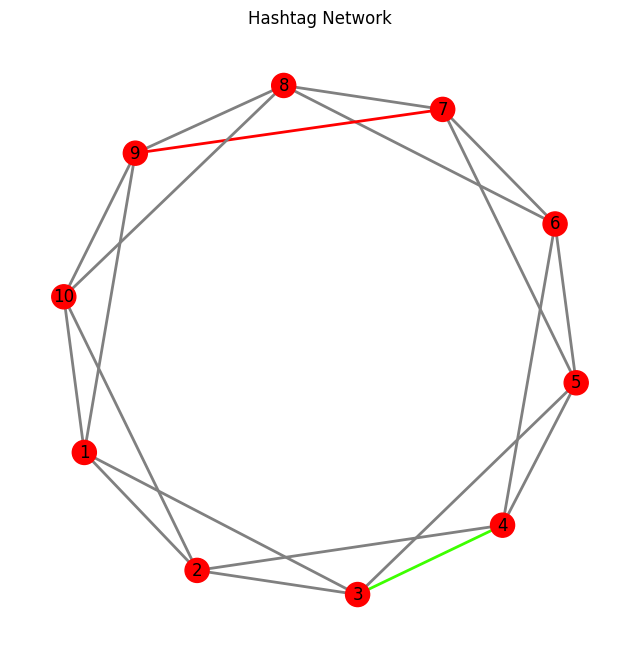

player #2 is paired with player #5 

player #7 is paired with player #1 

player #10 is paired with player #6 

player #8 is paired with player #4 

player #9 is paired with player #3 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
2, #FukushimaDisasterLegacy, #ClimateChange
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisaster
5, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
6, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
7, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
8, #FukushimaDisasterLegacy, #FukushimaDisaster
9, #FukushimaDisasterLegacy, #FukushimaDisaster
10, #FukushimaDisasterLegacy, #FukushimaDisasterAnniversary
11, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery 

Player: player #2, Hashtag: #FukushimaDisasterLegacy

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisasterAnniversary
3, #FukushimaDis

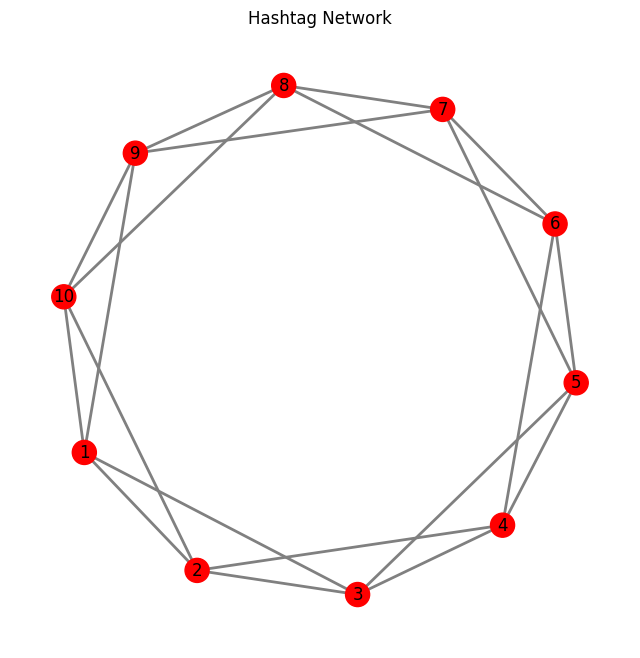

player #7 is paired with player #1 

player #10 is paired with player #5 

player #3 is paired with player #2 

player #8 is paired with player #4 

player #9 is paired with player #6 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaDisaster, #FukushimaNuclearDisaster
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisasterLegacy
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisasterRecovery 

Player: player #7, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
2, #FukushimaDisasterRecovery, #FukushimaDisasterLegacy
3, #FukushimaDisasterRecovery, #F

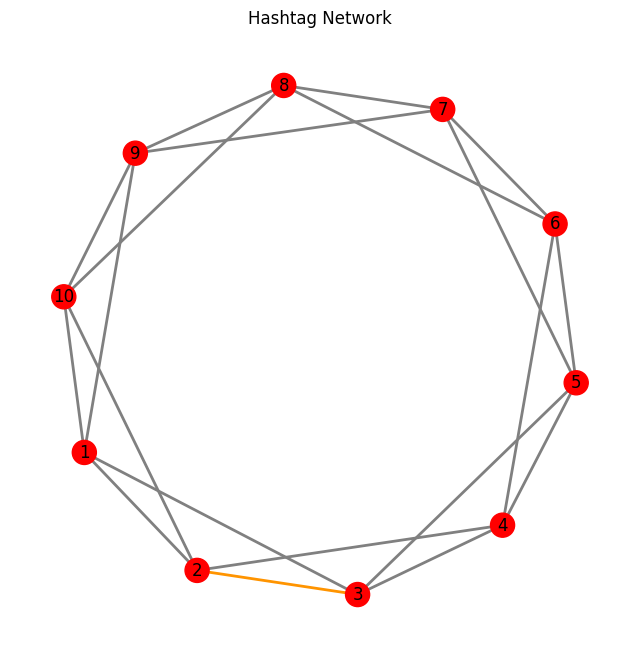

player #6 is paired with player #9 

player #10 is paired with player #2 

player #1 is paired with player #8 

player #4 is paired with player #3 

player #7 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster 

Player: player #6, Hashtag: #FukushimaNuclearDisaster

Round, Your Guess, Neighbor's Gues

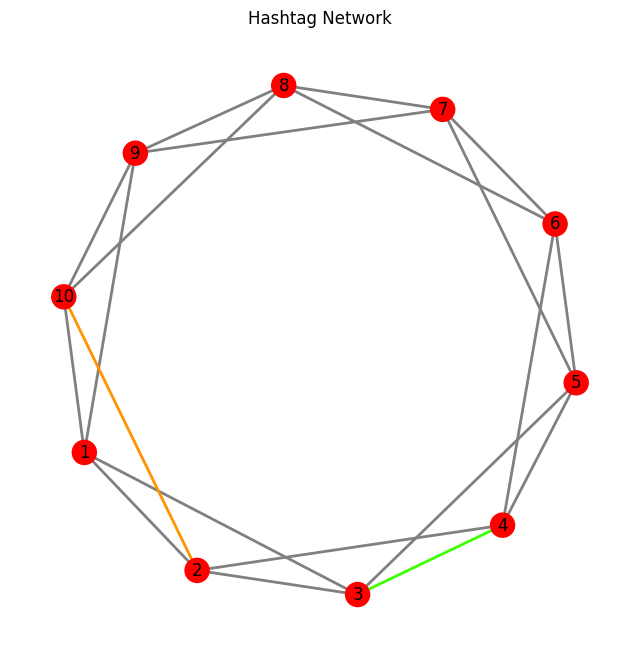

player #7 is paired with player #5 

player #9 is paired with player #3 

player #10 is paired with player #1 

player #6 is paired with player #4 

player #8 is paired with player #2 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaDisaster, #FukushimaNuclearDisaster
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisasterLegacy
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisasterRecovery
13, #FukushimaDisaster, #FukushimaDisasterRecovery
14, #FukushimaDisaster, #FukushimaDisasterLegacy 

Player: player #7, Hashtag: #FukushimaDisaster

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, 

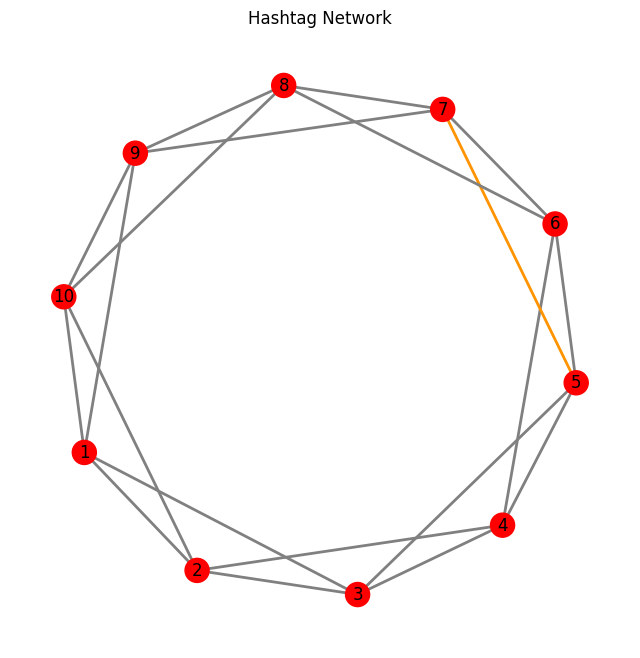

player #8 is paired with player #1 

player #9 is paired with player #3 

player #7 is paired with player #10 

player #4 is paired with player #6 

player #2 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
4, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
5, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
6, #FukushimaDisasterAnniversary, #FukushimaDisaster
7, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
8, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
9, #FukushimaDisasterAnniversary, #FukushimaDisaster
10, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
11, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
12, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
13, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
14, #FukushimaDisaster

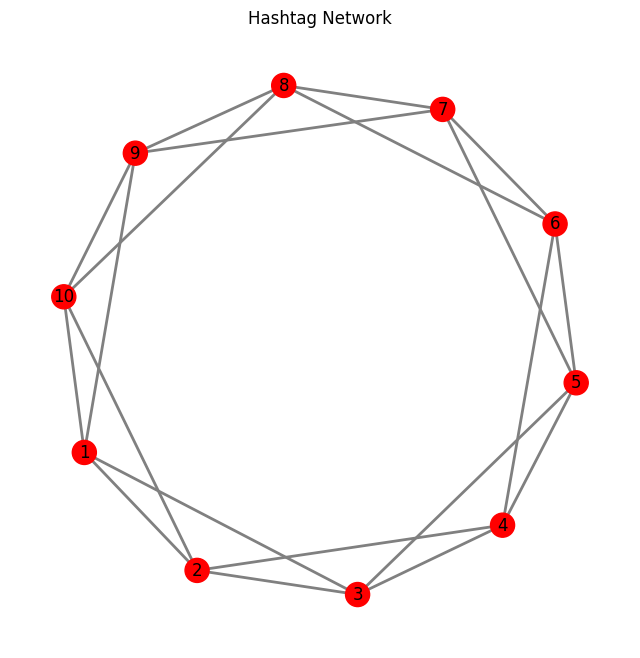

player #10 is paired with player #5 

player #3 is paired with player #8 

player #7 is paired with player #2 

player #9 is paired with player #6 

player #1 is paired with player #4 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
2, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisaster
5, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
6, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
7, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
8, #FukushimaDisasterLegacy, #FukushimaDisaster
9, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
10, #FukushimaDisasterLegacy, #FukushimaNuclearDisaster
11, #FukushimaDisasterLegacy, #FukushimaDisaster
12, #FukushimaDisasterLegacy, #FukushimaNuclearDisaster
13, #FukushimaDisasterLegacy, #FukushimaDisaster
14, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
15, #FukushimaDisasterLegacy, #Fu

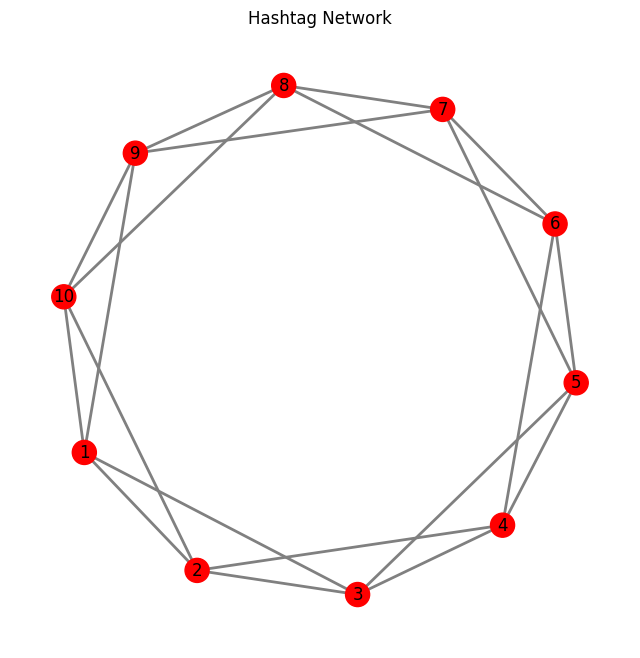

player #6 is paired with player #9 

player #3 is paired with player #8 

player #5 is paired with player #4 

player #2 is paired with player #7 

player #1 is paired with player #10 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaNuclearDisaster, #FukushimaDisaster
15, #FukushimaNuclearDisaster, #Fukushima

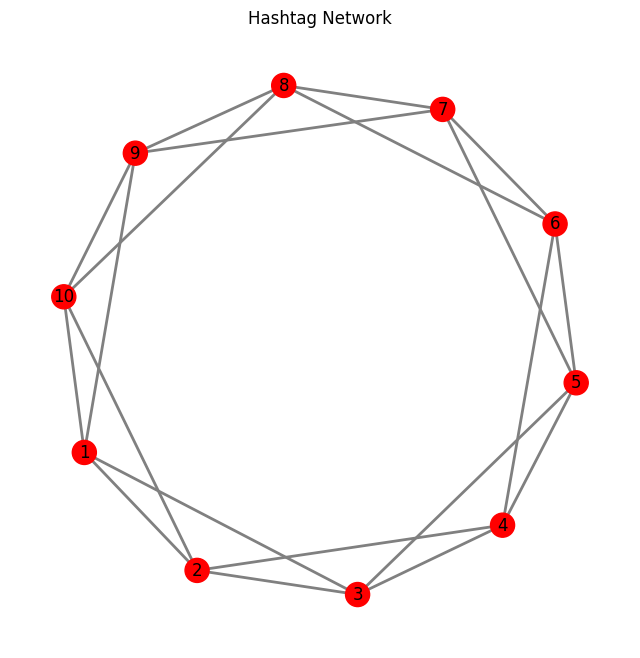

player #6 is paired with player #4 

player #1 is paired with player #5 

player #10 is paired with player #9 

player #7 is paired with player #8 

player #3 is paired with player #2 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaNuclearDisaster, #FukushimaDisaster
15, #FukushimaNuclearDisaster, #Fukushima

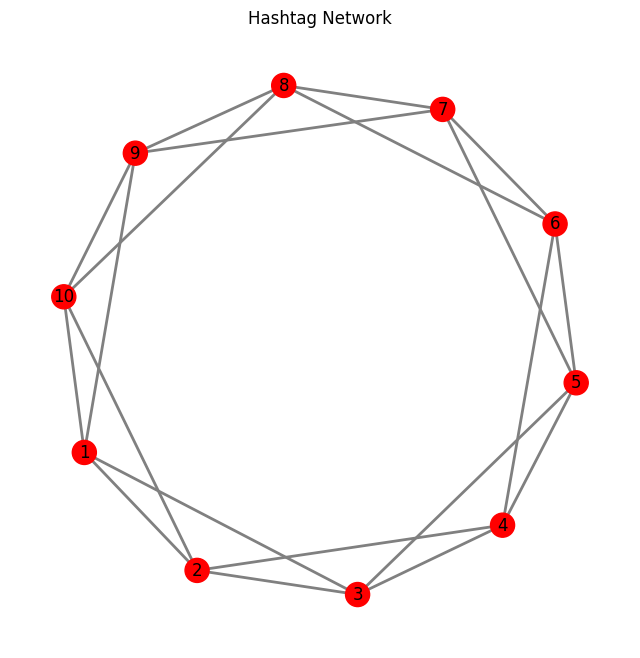

player #8 is paired with player #1 

player #6 is paired with player #7 

player #5 is paired with player #10 

player #9 is paired with player #2 

player #3 is paired with player #4 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
4, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
5, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
6, #FukushimaDisasterAnniversary, #FukushimaDisaster
7, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
8, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
9, #FukushimaDisasterAnniversary, #FukushimaDisaster
10, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
11, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
12, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
13, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
14, #FukushimaDisaster

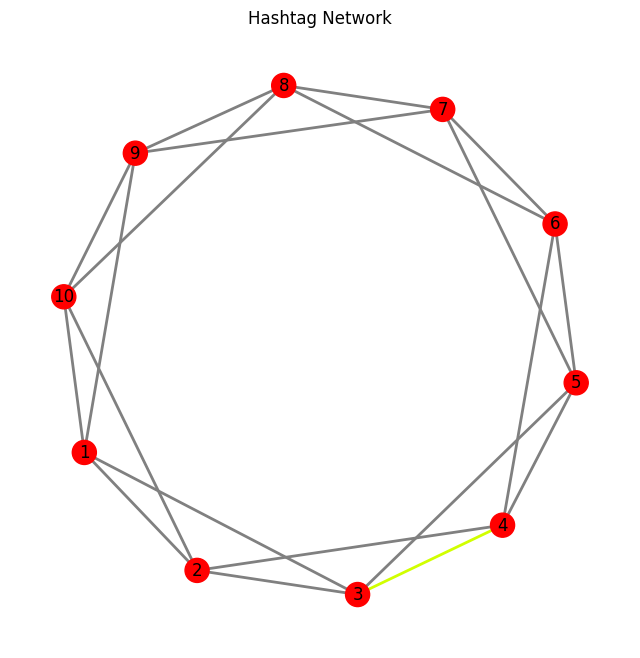

player #8 is paired with player #10 

player #5 is paired with player #6 

player #1 is paired with player #2 

player #7 is paired with player #4 

player #9 is paired with player #3 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
2, #FukushimaDisasterAnniversary, #FukushimaDisaster
3, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
4, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
5, #FukushimaDisasterAnniversary, #FukushimaDisasterRecovery
6, #FukushimaDisasterAnniversary, #FukushimaDisaster
7, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
8, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
9, #FukushimaDisasterAnniversary, #FukushimaDisaster
10, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
11, #FukushimaDisasterAnniversary, #FukushimaNuclearDisaster
12, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
13, #FukushimaDisasterAnniversary, #FukushimaDisasterLegacy
14, #FukushimaDisaster

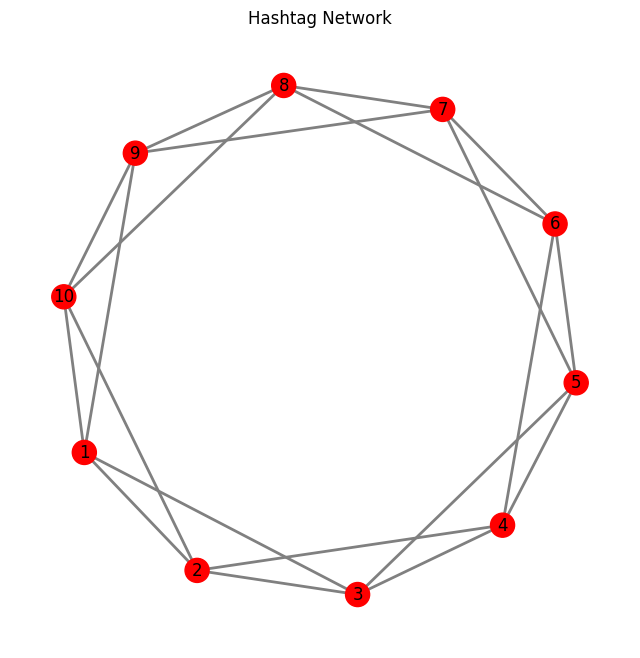

player #6 is paired with player #10 

player #2 is paired with player #8 

player #5 is paired with player #9 

player #7 is paired with player #3 

player #1 is paired with player #4 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaNuclearDisaster, #FukushimaDisaster
15, #FukushimaNuclearDisaster, #Fukushima

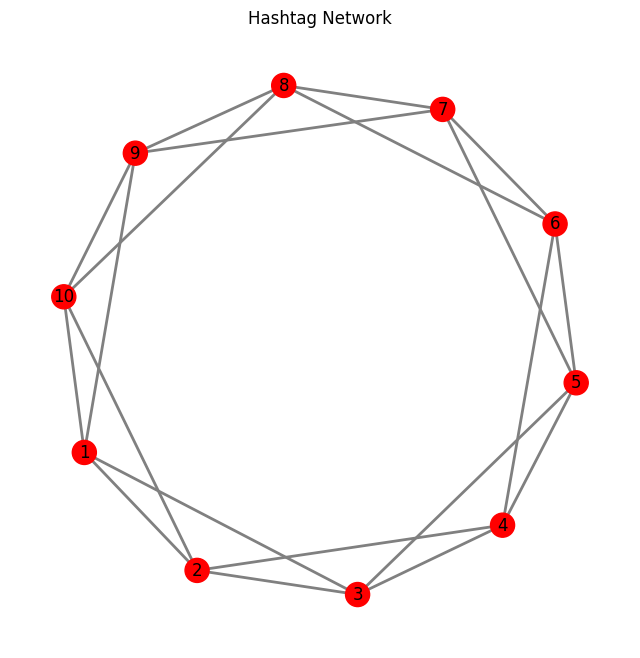

player #6 is paired with player #4 

player #10 is paired with player #2 

player #8 is paired with player #1 

player #9 is paired with player #7 

player #3 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaNuclearDisaster, #FukushimaDisaster
15, #FukushimaNuclearDisaster, #Fukushima

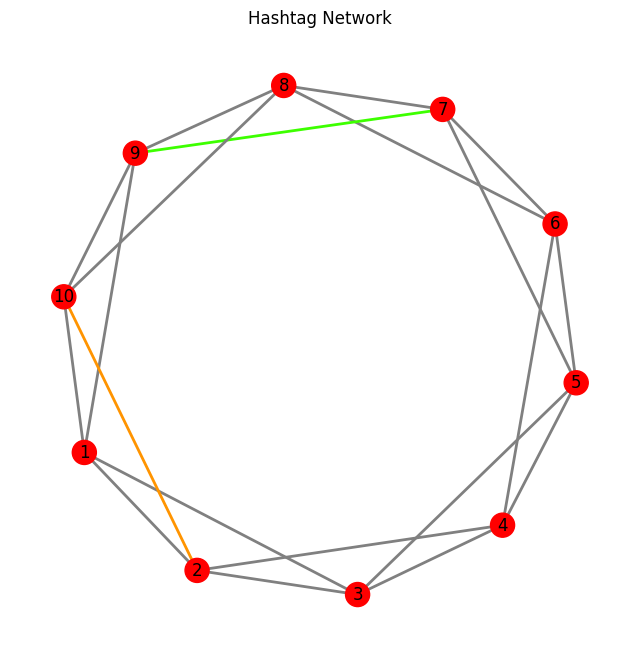

player #3 is paired with player #1 

player #6 is paired with player #5 

player #4 is paired with player #10 

player #8 is paired with player #7 

player #2 is paired with player #9 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
2, #ClimateChange, #FukushimaDisasterLegacy
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
5, #FukushimaDisasterLegacy, #FukushimaDisaster
6, #FukushimaDisasterLegacy, #FukushimaDisasterAnniversary
7, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
8, #FukushimaDisasterLegacy, #FukushimaDisaster
9, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
10, #FukushimaDisasterLegacy, #FukushimaDisaster
11, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
12, #FukushimaDisaster, #FukushimaDisaster
13, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
14, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
15, #FukushimaDisasterLegacy, #FukushimaDisaster
1

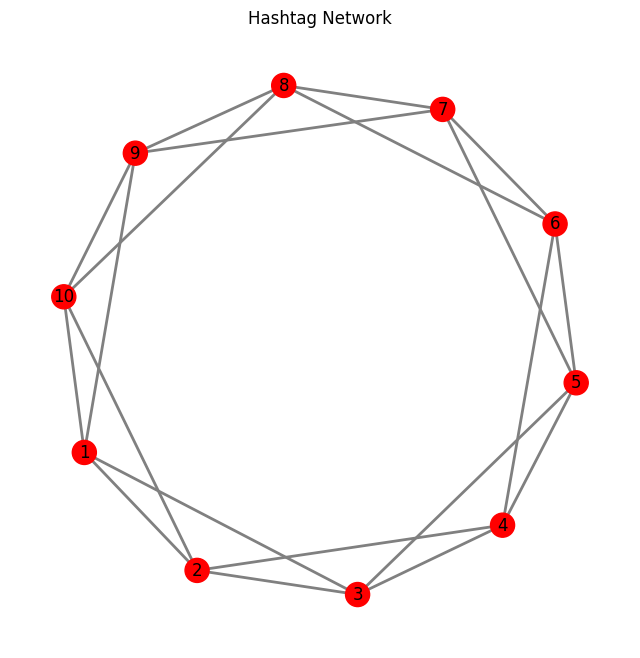

player #6 is paired with player #8 

player #9 is paired with player #4 

player #2 is paired with player #5 

player #3 is paired with player #7 

player #1 is paired with player #10 

Round, Your Guess, Neighbor's Guess
1, #FukushimaNuclearDisaster, #FukushimaDisaster
2, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
3, #FukushimaNuclearDisaster, #FukushimaDisaster
4, #FukushimaNuclearDisaster, #FukushimaDisaster
5, #FukushimaNuclearDisaster, #FukushimaDisaster
6, #FukushimaNuclearDisaster, #FukushimaDisasterRecovery
7, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
8, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisasterLegacy
10, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
11, #FukushimaNuclearDisaster, #FukushimaDisasterAnniversary
12, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaNuclearDisaster, #FukushimaDisaster
15, #FukushimaNuclearDisaster, #Fukushima

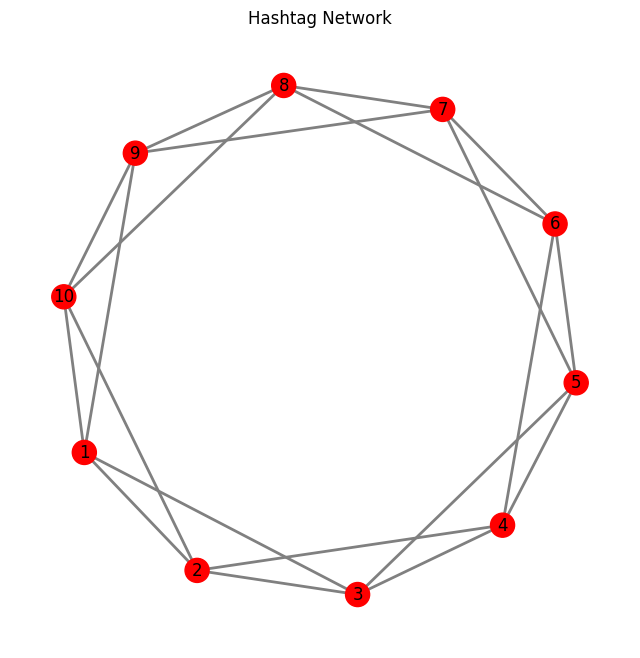

player #9 is paired with player #3 

player #2 is paired with player #6 

player #7 is paired with player #5 

player #4 is paired with player #1 

player #10 is paired with player #8 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaNuclearDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisaster
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisaster
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaDisaster, #FukushimaNuclearDisaster
15, #FukushimaDisaster, #FukushimaDisasterLegacy
16, #FukushimaDisaster, #FukushimaDisasterLegacy
17, #FukushimaDisaster, #FukushimaDisasterLegacy

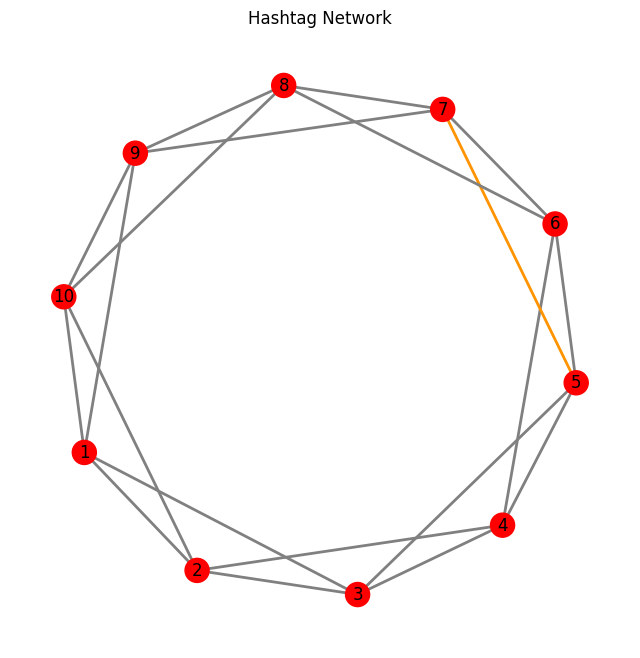

player #7 is paired with player #6 

player #5 is paired with player #9 

player #10 is paired with player #3 

player #4 is paired with player #8 

player #1 is paired with player #2 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaDisaster, #FukushimaNuclearDisaster
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisasterLegacy
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisasterRecovery
13, #FukushimaDisaster, #FukushimaDisasterRecovery
14, #FukushimaDisaster, #FukushimaDisasterLegacy
15, #FukushimaDisaster, #FukushimaDisaster
16, #FukushimaDisaster, #FukushimaDisasterLegacy
17, #FukushimaDisaster, #FukushimaDisas

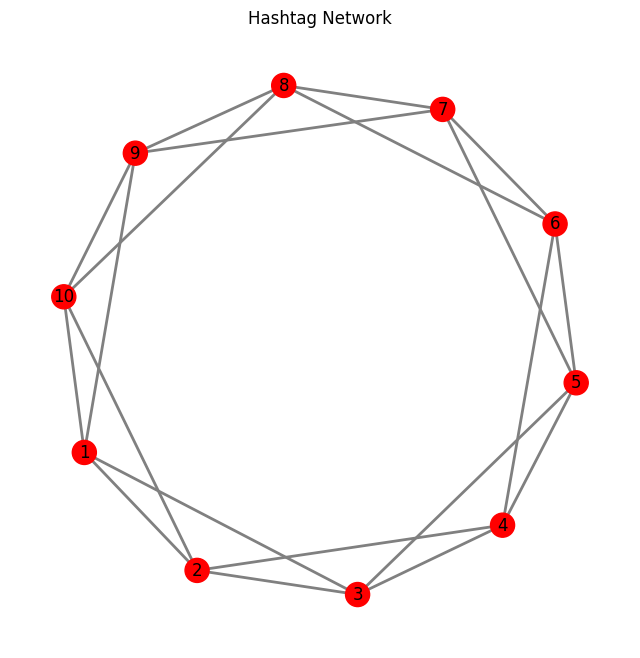

player #7 is paired with player #8 

player #6 is paired with player #10 

player #9 is paired with player #2 

player #1 is paired with player #5 

player #3 is paired with player #4 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaNuclearDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaDisaster, #FukushimaNuclearDisaster
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisasterLegacy
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisasterRecovery
13, #FukushimaDisaster, #FukushimaDisasterRecovery
14, #FukushimaDisaster, #FukushimaDisasterLegacy
15, #FukushimaDisaster, #FukushimaDisaster
16, #FukushimaDisaster, #FukushimaDisasterLegacy
17, #FukushimaDisaster, #FukushimaDisas

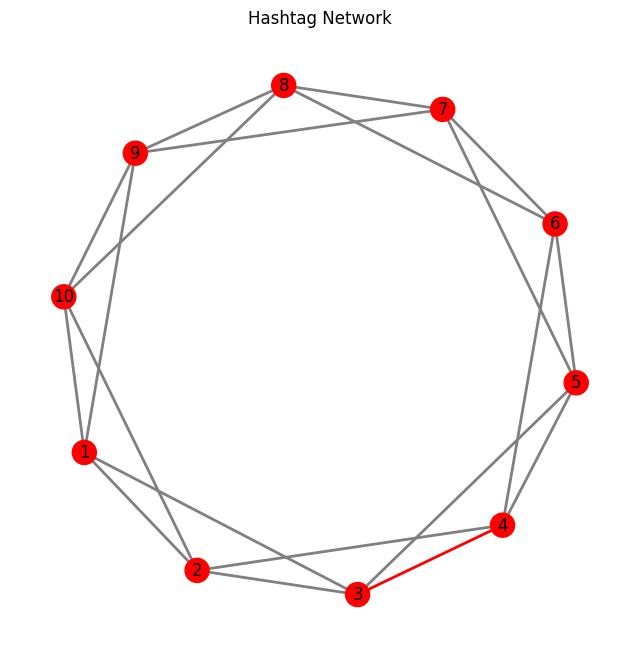

player #9 is paired with player #3 

player #1 is paired with player #8 

player #10 is paired with player #6 

player #2 is paired with player #4 

player #7 is paired with player #5 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisaster, #FukushimaNuclearDisaster
2, #FukushimaDisaster, #FukushimaDisaster
3, #FukushimaDisaster, #FukushimaDisaster
4, #FukushimaDisaster, #FukushimaDisasterLegacy
5, #FukushimaNuclearDisaster, #FukushimaDisasterLegacy
6, #FukushimaDisaster, #FukushimaDisaster
7, #FukushimaDisaster, #FukushimaDisaster
8, #FukushimaDisaster, #FukushimaDisasterLegacy
9, #FukushimaDisaster, #FukushimaDisaster
10, #FukushimaDisaster, #FukushimaDisaster
11, #FukushimaDisaster, #FukushimaDisaster
12, #FukushimaDisaster, #FukushimaDisaster
13, #FukushimaDisaster, #FukushimaDisaster
14, #FukushimaDisaster, #FukushimaNuclearDisaster
15, #FukushimaDisaster, #FukushimaDisasterLegacy
16, #FukushimaDisaster, #FukushimaDisasterLegacy
17, #FukushimaDisaster, #FukushimaDisasterLegacy

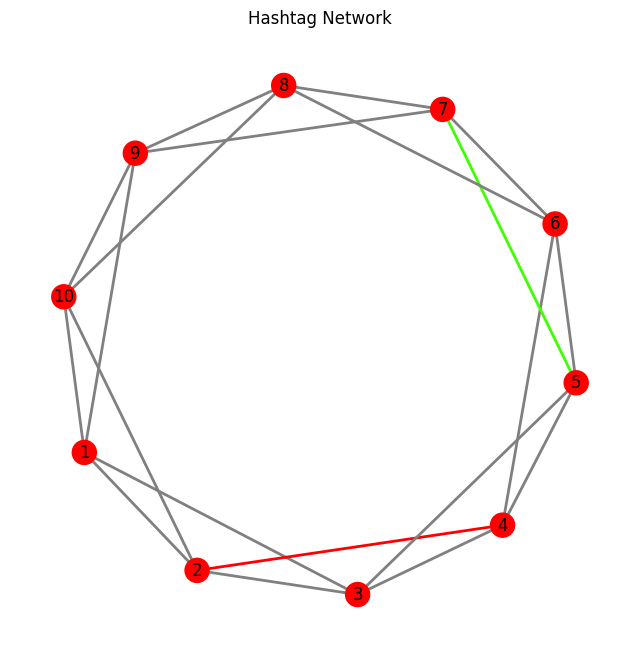

player #2 is paired with player #5 

player #10 is paired with player #3 

player #7 is paired with player #4 

player #8 is paired with player #6 

player #9 is paired with player #1 

Round, Your Guess, Neighbor's Guess
1, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
2, #FukushimaDisasterLegacy, #ClimateChange
3, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
4, #FukushimaDisasterLegacy, #FukushimaDisaster
5, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
6, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
7, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
8, #FukushimaDisasterLegacy, #FukushimaDisaster
9, #FukushimaDisasterLegacy, #FukushimaDisaster
10, #FukushimaDisasterLegacy, #FukushimaDisasterAnniversary
11, #FukushimaDisasterLegacy, #FukushimaDisasterRecovery
12, #FukushimaDisasterLegacy, #FukushimaDisaster
13, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
14, #FukushimaDisasterLegacy, #FukushimaDisasterLegacy
15, #FukushimaDisasterLegacy, #FukushimaDisa

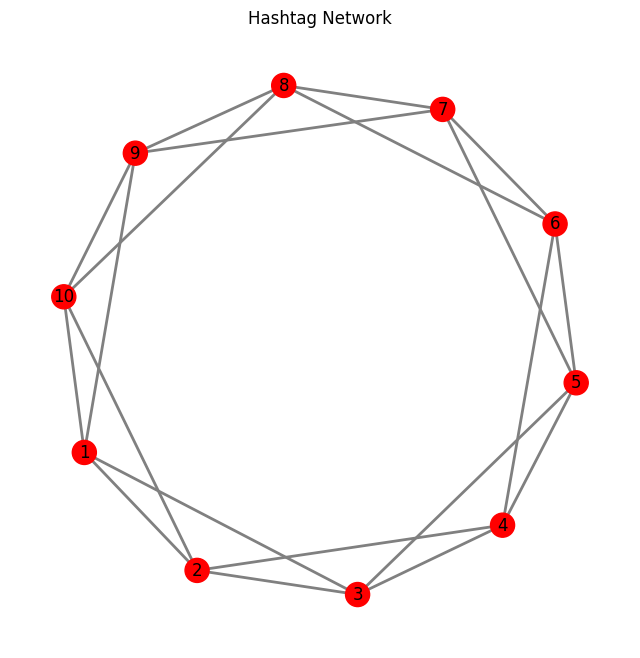

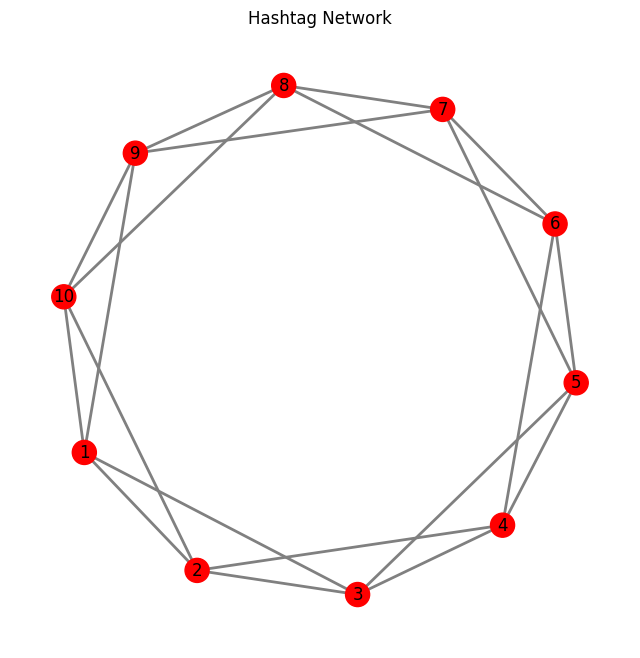

Scores: {'player #1': 2, 'player #2': 9, 'player #3': 13, 'player #4': 11, 'player #5': 9, 'player #6': 2, 'player #7': 10, 'player #8': 2, 'player #9': 14, 'player #10': 10}


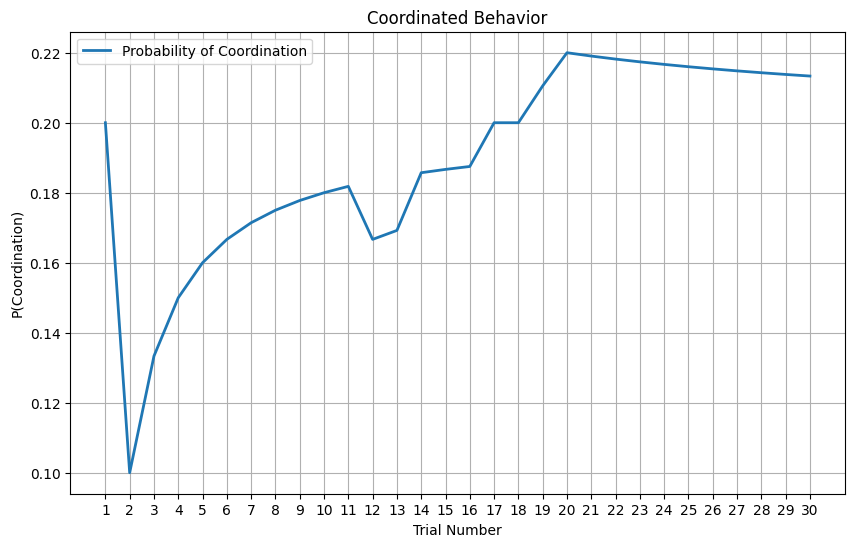

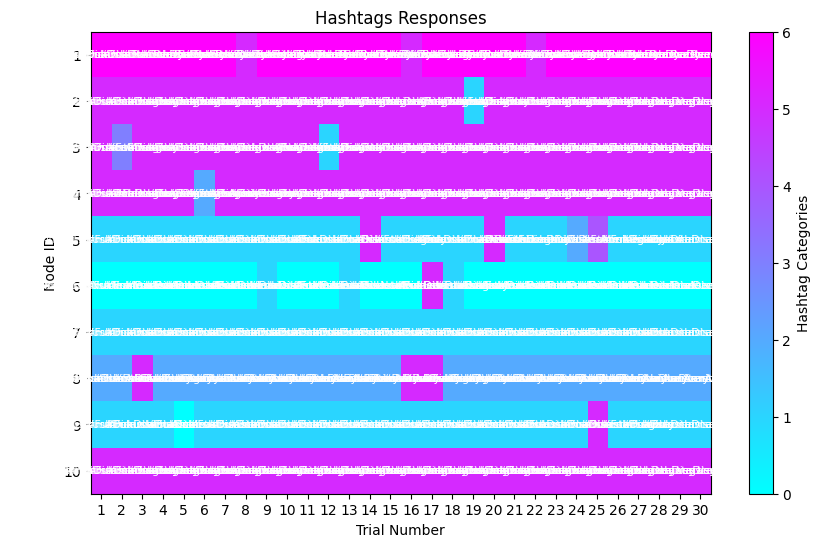

In [24]:
if __name__ == "__main__":
    
    network_graph = generate_network(num_nodes = 10, network = "spatial")
    
    hashtag_game = HashtagMessagePassing(network_graph)
    
    
    hashtag_game.play_game()

    